# CNN Auto-Encoder model for anomalies detection

In [60]:
# ---- utils libs ----
import numpy as np
import pandas as pd
import datetime
from typing import Optional
from module import load_dataset, time_in_range, segmentDf, create_sequence, train_test_split_dataset, convertToSequenceParameters
from pathlib import Path
import pathlib

# ---- Data Viz libs ---- 
from matplotlib import pyplot as plt
import plotly.graph_objects as go

# ---- ML libs ----
from sklearn.preprocessing import StandardScaler

# ---- Deep Learning libs ----
from tensorflow import keras
from tensorflow.keras import layers

## Load Dataset

In [61]:
os.getcwd()

'c:\\Users\\Pierrick\\OneDrive\\Bureau\\K\\2_MS_TelecomParis\\Cours\\Projet_Fil_Rouge\\Activity_Detection_From_Electrical_Consumption_Load_Curves\\Auto Encodeur CNN'

In [62]:
path = Path(os.getcwd())

# Path('data/house1_power_blk2_labels.csv')
path = path.parent.parent.absolute() / 'data' / "house1_power_blk2_labels"/ "house1_power_blk2_labels.csv"
path

WindowsPath('c:/Users/Pierrick/OneDrive/Bureau/K/2_MS_TelecomParis/Cours/Projet_Fil_Rouge/data/house1_power_blk2_labels/house1_power_blk2_labels.csv')

In [63]:
dataset_resampled_1H = load_dataset(path, "60min")
dataset_resampled_1H = dataset_resampled_1H["mains"]
df_mains_resampled_1H = pd.DataFrame(dataset_resampled_1H)
df_mains_resampled_1H

,mains
datetime,
2016-03-06 00:00:00,473.0
2016-03-06 01:00:00,736.0
2016-03-06 02:00:00,479.0
2016-03-06 03:00:00,467.0
2016-03-06 04:00:00,610.0
...,...
2016-05-07 18:00:00,1413.0
2016-05-07 19:00:00,1608.0
2016-05-07 20:00:00,1116.0


## Visualize Load Curve

In [64]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_mains_resampled_1H.index, y=df_mains_resampled_1H['mains'], name='Load Curve'))
fig.update_layout(showlegend=True, title='house1_power_blk2_labels_60min')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## Preprocessing

####  1/ Loads the dataset and resample timeseries
####  2/ Split a dataframe into train set and test set according to the split rate
####  3/ Standardize Data
####  4/ Construction of the dataset according to peak and off-peak hours or according to activity labels
####  5/ Creation of sequences of length T and according to the overlapping period

#### Return preprocessed ``3D-array`` ``[samples, SEQUENCE_LENGTH, features]`` (i.e sequences from the timeseries) , as required for **LSTM** network. We want our network to have memory of **10 days**, so we set ``SEQUENCE_LENGTH=10``.

#### Define Global Hyperparmètre

In [65]:
TIME_STEP = datetime.timedelta(minutes=1, seconds=30) # duration of a step in the resample dataset, originally 1second
DURATION_TIME = datetime.timedelta(minutes=60) # duration of a sequence
OVERLAP_PERIOD_PERCENT = 0.8 # 0.5 <=> 50% overlapping
TIMEFRAMES = [(datetime.time(22,0,0), datetime.time(6,0,0))]

SEQUENCE_LENGTH, OVERLAP_PERIOD = convertToSequenceParameters(TIME_STEP, DURATION_TIME, OVERLAP_PERIOD_PERCENT)

print("\t\tValeur choisie \t Equivalent sequence\nTimestep : \t {}\nDuration :\t {} \t -->  {} \nOverlap :\t {} \t -->  {}".format(TIME_STEP, DURATION_TIME, SEQUENCE_LENGTH, OVERLAP_PERIOD_PERCENT, OVERLAP_PERIOD))

		Valeur choisie 	 Equivalent sequence
Timestep : 	 0:01:30
Duration :	 1:00:00 	 -->  40 
Overlap :	 0.8 	 -->  32


In [66]:
def preprocessing(filepath: str, timeframes: list
                  ,sequence_length: int, overlap_period: int
                  ,resample_period :Optional[str]=None
                  ,use_labels :Optional[bool]=False, split_rate :Optional[float]=0.2) -> np.array:
    """
    1/ Loads the dataset and resample timeseries
    2/ Split a dataframe into train set and test set according to the split rate
    3/ Standardize Data
    4/ Construction of the dataset according to peak and off-peak hours 
    or according to activity labels
    5/ Creation of sequences of length T and according to the overlapping period
    
    Args:
        - filename: the path to the file to load
        - resample_period: (optional) the reasmple period, if None the default period of 1 second will be used
        - df: dataframe with a hands column indicating the instantaneous power and the datetime as index
        - timeframes: list of tuples indicating the periods of the day ex: timeframes = [(datetime.time(10,0,0), datetime.time(6,0,0)), (datetime.time(12,0,0), datetime.time(13,0,0))
        - use_labels: (False by default) use the activities labels
        - sequence_length: length of the sequence
        - overlap_period: overlap the sequences of timeseries
        - split_rate: Rate of the test set size
    Returns: 
        - list of prepocessed 3D-array [samples, sequence_length, features] (i.e sequences from the timeseries) 
    """
    # load dataset and resampled timeseries
    df_resampled = load_dataset(filepath, resample_period)
    
    # split dataframe into train set and test set
    train_df, test_df = train_test_split_dataset(df_resampled)
    
    # Standardize Data
    scaler = StandardScaler()
    scaler_train = scaler.fit(train_df[['mains']])
    scaler_test = scaler.fit(test_df[['mains']])
    
    train_df['mains'] = scaler_train.transform(train_df[['mains']])
    test_df['mains'] = scaler_test.transform(test_df[['mains']])
    
    # --- TRAIN SEQUENCES ----
    # Construction of the dataset according to peak and off-peak hours 
    list_df_train = segmentDf(train_df, timeframes = timeframes)
    
    # init 3D-array [samples, sequence_length, features]
    first_df_train = list_df_train[0]
    list_X_sequence_train, list_y_sequence_train = create_sequence(first_df_train, sequence_length, overlap_period)
    list_df_train.pop(0) # delete the first element of the list of train dataframes
    
    # Creation of sequences of length T and according to the overlapping period
    for df_train_ in list_df_train:
        X_sequences_train, y_sequences_train = create_sequence(df_train_, sequence_length, overlap_period)
        list_X_sequence_train = np.append(list_X_sequence_train, X_sequences_train, axis = 0)
        list_y_sequence_train = np.append(list_y_sequence_train, y_sequences_train, axis = 0)
        
    # ---- TEST SEQUENCES ----
    X_sequences_test, y_sequences_test = create_sequence(test_df, sequence_length, overlap_period)
    
    return train_df, test_df, list_X_sequence_train, list_y_sequence_train, X_sequences_test, y_sequences_test

In [68]:
train_df, test_df, X_train, y_train, X_test, y_test = preprocessing(filepath = path
                          ,timeframes = TIMEFRAMES
                          ,sequence_length = SEQUENCE_LENGTH, overlap_period = OVERLAP_PERIOD, resample_period = TIME_STEP)

C:\Users\Pierrick\AppData\Local\Temp/ipykernel_24428/2330807064.py:36: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Pierrick\AppData\Local\Temp/ipykernel_24428/2330807064.py:37: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [69]:
print("---- train DataFrame shape ----")
train_df.shape

---- train DataFrame shape ----


(48352, 3)

In [70]:
print("---- test DataFrame shape ----")
test_df.shape

---- test DataFrame shape ----


(12088, 3)

### Verify the shape of the sequence

In [71]:
print("---- X_train sequence shape ----")
print(X_train.shape)

print("\n---- y_train sequence shape ----")
print(y_train.shape)

print("\n\n---- X_test sequence shape ----")
print(X_test.shape)

print("\n---- y_test sequence shape ----")
print(y_test.shape)

---- X_train sequence shape ----
(1826, 40, 1)

---- y_train sequence shape ----
(1826, 40, 2)


---- X_test sequence shape ----
(1506, 40, 1)

---- y_test sequence shape ----
(1506, 40, 2)


### Visualize the sequence

In [72]:
print("---- X_train sequence ----")
X_train

---- X_train sequence ----


array([[[-0.59421227],
        [-0.57840191],
        [-0.59263123],
        ...,
        [-0.76338314],
        [-0.62108988],
        [-0.12780661]],

       [[-0.60527952],
        [-0.35231374],
        [-0.38235343],
        ...,
        [-0.79026075],
        [-0.78235557],
        [-0.76022106]],

       [[-0.57682087],
        [-0.58156398],
        [-0.58156398],
        ...,
        [-0.1799808 ],
        [ 0.01448664],
        [-0.19579117]],

       ...,

       [[-0.44085177],
        [-0.43768969],
        [-0.41871726],
        ...,
        [ 4.53150687],
        [ 3.02636047],
        [ 5.81688924]],

       [[-0.64480543],
        [-0.64164335],
        [-0.64954853],
        ...,
        [ 2.67378941],
        [ 2.67378941],
        [-0.24638432]],

       [[ 0.32278869],
        [ 0.24847999],
        [ 3.14177611],
        ...,
        [ 0.33385594],
        [ 0.45717676],
        [ 0.44294743]]])

In [73]:
print("---- y_train sequence ----")
y_train

---- y_train sequence ----


array([[[Timestamp('2016-03-06 00:00:00'), 0],
        [Timestamp('2016-03-06 00:01:30'), 0],
        [Timestamp('2016-03-06 00:03:00'), 0],
        ...,
        [Timestamp('2016-03-06 00:55:30'), 0],
        [Timestamp('2016-03-06 00:57:00'), 0],
        [Timestamp('2016-03-06 00:58:30'), 0]],

       [[Timestamp('2016-03-06 00:12:00'), 0],
        [Timestamp('2016-03-06 00:13:30'), 0],
        [Timestamp('2016-03-06 00:15:00'), 0],
        ...,
        [Timestamp('2016-03-06 01:07:30'), 0],
        [Timestamp('2016-03-06 01:09:00'), 0],
        [Timestamp('2016-03-06 01:10:30'), 0]],

       [[Timestamp('2016-03-06 00:24:00'), 0],
        [Timestamp('2016-03-06 00:25:30'), 0],
        [Timestamp('2016-03-06 00:27:00'), 0],
        ...,
        [Timestamp('2016-03-06 01:19:30'), 0],
        [Timestamp('2016-03-06 01:21:00'), 0],
        [Timestamp('2016-03-06 01:22:30'), 0]],

       ...,

       [[Timestamp('2016-04-25 04:36:00'), 0],
        [Timestamp('2016-04-25 04:37:30'), 0],
  

In [74]:
print("---- X_test sequence ----")
X_test

---- X_test sequence ----


array([[[-0.18472391],
        [-0.51041736],
        [-0.51357943],
        ...,
        [-0.33176027],
        [-0.18156184],
        [ 0.03187804]],

       [[-0.39658275],
        [-0.15152215],
        [-0.39342068],
        ...,
        [-0.38077239],
        [-0.2716809 ],
        [-0.28749126]],

       [[ 0.01132457],
        [-0.1973722 ],
        [-0.03136341],
        ...,
        [-0.18472391],
        [-0.02345823],
        [-0.18156184]],

       ...,

       [[ 0.31330247],
        [ 0.28800589],
        [ 0.44927158],
        ...,
        [-0.38235343],
        [-0.54361911],
        [-0.54994326]],

       [[-0.35389478],
        [-0.3855155 ],
        [-0.46614834],
        ...,
        [-0.15152215],
        [-0.35705685],
        [-0.37761032]],

       [[-0.19104806],
        [-0.19421013],
        [-0.3855155 ],
        ...,
        [-0.58314502],
        [-0.57682087],
        [-0.34757063]]])

In [75]:
print("---- y_test sequence ----")
y_test

---- y_test sequence ----


array([[[Timestamp('2016-04-25 08:48:00'), 0],
        [Timestamp('2016-04-25 08:49:30'), 0],
        [Timestamp('2016-04-25 08:51:00'), 0],
        ...,
        [Timestamp('2016-04-25 09:43:30'), 0],
        [Timestamp('2016-04-25 09:45:00'), 0],
        [Timestamp('2016-04-25 09:46:30'), 0]],

       [[Timestamp('2016-04-25 09:00:00'), 0],
        [Timestamp('2016-04-25 09:01:30'), 0],
        [Timestamp('2016-04-25 09:03:00'), 0],
        ...,
        [Timestamp('2016-04-25 09:55:30'), 0],
        [Timestamp('2016-04-25 09:57:00'), 0],
        [Timestamp('2016-04-25 09:58:30'), 0]],

       [[Timestamp('2016-04-25 09:12:00'), 0],
        [Timestamp('2016-04-25 09:13:30'), 0],
        [Timestamp('2016-04-25 09:15:00'), 0],
        ...,
        [Timestamp('2016-04-25 10:07:30'), 0],
        [Timestamp('2016-04-25 10:09:00'), 0],
        [Timestamp('2016-04-25 10:10:30'), 0]],

       ...,

       [[Timestamp('2016-05-07 21:24:00'), 1],
        [Timestamp('2016-05-07 21:25:30'), 1],
  

## Build a model

We will build a convolutional reconstruction autoencoder model. The model will take input of shape (``batch_size``, ``sequence_length``, ``num_features``) and return output of the same shape. In this case, ``sequence_length`` is **10** and ``num_features`` is **1**.

In [76]:
X_train.shape # 3d Array (samples, SEQUENCE_LENGTH, num_features)

(1826, 40, 1)

In [77]:
X_train.shape[1]

40

In [78]:
X_train.shape[2]

1

In [79]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=4, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 20, 32)            256       
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 20, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 20, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 40, 32)           3616      
 ranspose)                                              

### Train the model

Please note that we are using ``X_train`` as both the input and the target since this is a reconstruction model.

In [80]:
history = model.fit(
    X_train,
    X_train,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
13/13 [==============================] - 2s 58ms/step - loss: 0.8722 - val_loss: 0.2754
Epoch 2/50
13/13 [==============================] - 0s 34ms/step - loss: 0.4201 - val_loss: 0.1158
Epoch 3/50
13/13 [==============================] - 0s 34ms/step - loss: 0.2463 - val_loss: 0.0918
Epoch 4/50
13/13 [==============================] - 0s 34ms/step - loss: 0.1913 - val_loss: 0.0788
Epoch 5/50
13/13 [==============================] - 0s 31ms/step - loss: 0.1632 - val_loss: 0.0705
Epoch 6/50
13/13 [==============================] - 0s 34ms/step - loss: 0.1415 - val_loss: 0.0607
Epoch 7/50
13/13 [==============================] - 1s 55ms/step - loss: 0.1206 - val_loss: 0.0525
Epoch 8/50
13/13 [==============================] - 0s 23ms/step - loss: 0.1058 - val_loss: 0.0478
Epoch 9/50
13/13 [==============================] - 0s 20ms/step - loss: 0.1003 - val_loss: 0.0456
Epoch 10/50
13/13 [==============================] - 0s 17ms/step - loss: 0.0894 - val_loss: 0.0438
Epoch 11/

### Evaluation of the model

Let's plot training and validation loss to see how the training went.

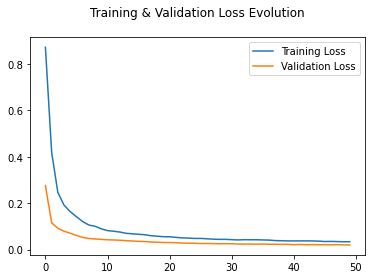

In [81]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Evolution\n")
plt.show()

### Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct the input data.

**1/** Find ``MAE`` loss on training samples.

**2/** Find max MAE loss value. This is the worst our model has performed trying to reconstruct a sample. We will make this the ``threshold`` for anomaly detection.

**3/** If the reconstruction loss for a sample is greater than this ``threshold`` value then we can infer that the model is seeing a pattern that it isn't familiar with. We will label this sample as an **anomaly.**

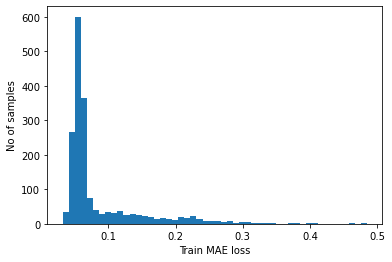

Reconstruction error threshold:  0.48459934701977636


In [82]:
# Get train MAE loss.
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample. This is the **40** timesteps from day 1 of our training dataset.

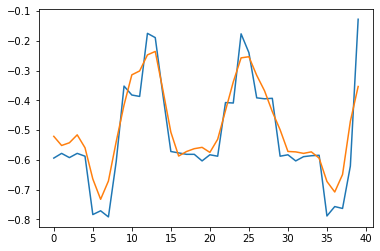

In [85]:
# Checking how the first sequence is learnt
plt.plot(X_train[0])
plt.plot(X_train_pred[0])
plt.show()

### Prepare test data

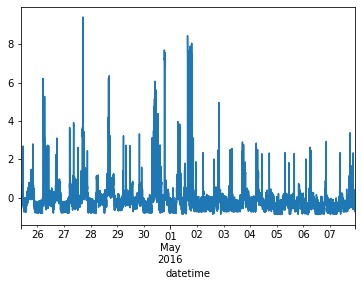

In [86]:
df_test_value = test_df["mains"]
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

In [87]:
print("Test input shape: ", X_test.shape)

Test input shape:  (1506, 40, 1)


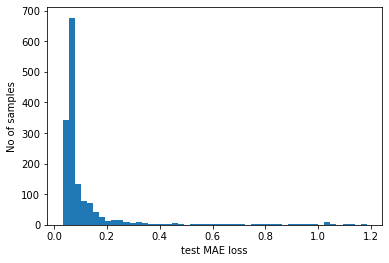

Number of anomaly samples: 
53


Indices of anomaly samples: 
(array([277, 278, 279, 280, 281, 282, 283, 284, 285, 393, 394, 395, 396,
       397, 398, 399, 400, 601, 602, 603, 604, 605, 606, 607, 608, 609,
       610, 611, 612, 647, 648, 649, 712, 713, 714, 715, 716, 717, 718,
       751, 752, 753, 754, 762, 763, 764, 765, 766, 767, 768, 769, 770,
       771], dtype=int64),)


In [88]:
# Get test MAE loss.
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ")
print(np.sum(anomalies))

print("\n\nIndices of anomaly samples: ")
print( np.where(anomalies))

### Plot anomalies

We now know the samples of the data which are anomalies. With this, we will find the corresponding timestamps from the original test data.

We will be using the following method to do that:

Let's say ``SEQUENCE_LENGTH = 3`` and we have **10** training values. Our ``x_train`` will look like this:

0, 1, 2

1, 2, 3

2, 3, 4

3, 4, 5

4, 5, 6

5, 6, 7

6, 7, 8

7, 8, 9

All except the initial and the final _SEQUENCE_LENGTH-1_ data values, will appear in time_steps number of samples. So, if we know that the samples [(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point **5** is an anomaly.

In [89]:
# data i is an anomaly if samples [(i - SEQUENCE_LENGTH + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(SEQUENCE_LENGTH - 1, len(df_test_value) - SEQUENCE_LENGTH + 1):
    if np.all(anomalies[data_idx - SEQUENCE_LENGTH + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)

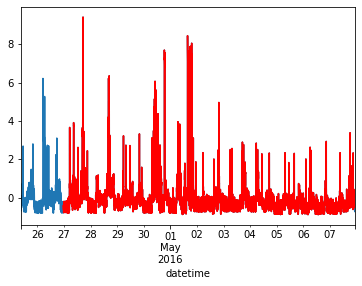

In [90]:
df_subset = df_test_value.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()